In [115]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

# Inputs

In [2]:
start_date = '20221130'
end_date = '20230509'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [3]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# Add momentum flux variable

In [4]:
tidy_df_5Min = tidy.tidy_df_add_variable(
    tidy_df_5Min,
    (
        tidy_df_5Min.query("variable == 'u_w__3m_c'")['value'].values**2 
        + tidy_df_5Min.query("variable == 'v_w__3m_c'")['value'].values**2
    ),
    'u_w_rot__3m_c',
    'u_w_rot__',
    3,
    'c'
)

# M.O.S.T. Scheme

We adapt a scheme described by Marks and Dozier (1992, see Equations 9 - 16), in which we solve a system of equations using a limited number of measurements. Our method differs in that we assume a constant measurement height for all measurements throughout our measurement period, even though the snow surface varys from 0 to 2 meters during the snow season. Note that our method differs from theirs in that we calculate momentum, sensible heat, and latent heat fluxes as positive AWAY from the surface.

We define 4 equations we want to solve, which correspond to 4 dependent variables. We also define stability functions for stable and unstable conditions (see the code).


*Marks, D., & Dozier, J. (1992). Climate and energy exchange at the snow surface in the Alpine Region of the Sierra Nevada: 2. Snow cover energy balance. Water Resources Research, 28(11), 3043–3054. https://doi.org/10.1029/92WR01483*

## Define Constants

In [5]:
VON_KARMAN_CONSTANT = 0.40 #dimensionless
GRAVITY = 9.81 # m/s^2
SNOW_SURFACE_ROUGHNESS = 1e-4 # m, Marks and Dozier report its in the range [1e-4, 5e-3]
ZERO_PLANE_DISPLACEMENT_HEIGHT = (2/3)*7.35*SNOW_SURFACE_ROUGHNESS # m
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_HEAT = 1.0 # dimensionless
RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_WATERVAPOR = 1.0 # dimensionless
AIR_SPECIFIC_HEAT = 1005 # J / kg / K

## Extract variables

In [132]:
VARIABLES = [
    'spd_3m_c',
    'Tpot_3m_c',
    'Tsurfpot_rad_c',
    'mixingratio_3m_c',
    'Tsurfmixingratio_rad_c',
    'airdensity_3m_c',
    'T_3m_c',
    'w_h2o__3m_c',
    'w_tc__3m_c',
    'u*_3m_c'
]

[ v for v in tidy_df_5Min.variable.unique() if v in VARIABLES ]

['w_h2o__3m_c',
 'spd_3m_c',
 'T_3m_c',
 'w_tc__3m_c',
 'Tpot_3m_c',
 'airdensity_3m_c',
 'mixingratio_3m_c',
 'Tsurfmixingratio_rad_c',
 'Tsurfpot_rad_c',
 'u*_3m_c']

In [133]:
variables_df = tidy_df_5Min[tidy_df_5Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

In [134]:
variables_df = variables_df.iloc[:10000]

## Make necessary conversions

In [9]:
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_rad_c'] = variables_df['Tsurfpot_rad_c'] + 273.15

# convert from g/g to g/kg
variables_df['mixingratio_3m_c'] = variables_df['mixingratio_3m_c']*1000
variables_df['Tsurfmixingratio_rad_c'] = variables_df['Tsurfmixingratio_rad_c']*1000

## Add measurement height variables (constants)

In [10]:
variables_df['measurement_height_windspeed'] = 3
variables_df['measurement_height_temperature'] = 3
variables_df['measurement_height_specifichumidity'] = 3

## Define helper functions

In [11]:
def stable_stability_function_generic(
    zeta # dimensionless
):
    return -5

def unstable_stability_function_heat_and_watervapor(
    zeta # dimensionless
):
    return 2*np.log(
        (1 + x_func(zeta)**2) / 2)

def x_func(
    zeta # dimensionless
):
    return (1 - 16*zeta)**(0.25)

## Define 7 equations

In [12]:
class MOST:
    
    def obukhov_stability_length(
        self,
        friction_velocity, # m/s 
        air_density, # kg/m^3 
        sensible_heat_flux, # W/m^2
        air_temperature, # K
        latent_heat_flux # kg/m^2/s
    ):
        """
        Returns Obukhov stability length, units of m.
        """
        return (
            (friction_velocity**3)*air_density
        ) / (
            VON_KARMAN_CONSTANT * GRAVITY * (
                (sensible_heat_flux / (air_temperature * AIR_SPECIFIC_HEAT))
                +
                0.61 * latent_heat_flux
            )
        )

    def friction_velocity(
        self,
        wind_speed, # m/s 
        measurement_height_above_snow_surface_windspeed, # of wind speed measurement, m
        stability_function_mass
    ):
        """
        Returns friction velocity, units of m/s.
        """
        return (
            wind_speed * VON_KARMAN_CONSTANT
        ) / (
            np.log(
                (measurement_height_above_snow_surface_windspeed - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_mass
        )

    def sensible_heat_flux(
        self,
        air_potential_temperature, # K
        snow_surface_potential_temperature, # K
        friction_velocity, # m/s
        air_density, # kg/m^3
        measurement_height_above_snow_surface_temperature, # of temperature measurement, m
        stability_function_heat # m
    ):
        """
        Returns sensible heat flux, positive away from the surface, units of W/m^2.
        """
        return - (
            (air_potential_temperature - snow_surface_potential_temperature)
            *
            RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_HEAT
            *
            VON_KARMAN_CONSTANT*friction_velocity*air_density*AIR_SPECIFIC_HEAT
        ) / (
            np.log(
                (measurement_height_above_snow_surface_temperature - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_heat
        )

    def latent_heat_flux(
        self,
        air_specific_humidity, # g / kg
        snow_surface_specific_humidity, # g / kg
        friction_velocity, # m/s
        air_density, # kg/m^3
        measurement_height_above_snow_surface_specifichumidity, # of specific humidity measurement
        stability_function_watervapor
    ):
        """
        Returns latent heat flux, positive away from the surface, units of kg/m^2/s.
        """
        return - (
            (air_specific_humidity - snow_surface_specific_humidity)
            *
            RATIO_OF_EDDY_DIFFUSIVITY_AND_VISCOSITY_FOR_WATERVAPOR
            *
            VON_KARMAN_CONSTANT*friction_velocity*air_density
        ) / (
            np.log(
                (measurement_height_above_snow_surface_specifichumidity - ZERO_PLANE_DISPLACEMENT_HEIGHT) / SNOW_SURFACE_ROUGHNESS
            )
            -
            stability_function_watervapor
        )

    def stability_function_mass(
        self,
        measurement_height_above_snow_surface_windspeed,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_windspeed / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return 2*np.log(
                (1 + x_func(zeta)) / 2
            ) + np.log(
                (1 + x_func(zeta)**2) / 2
            ) - 2*np.arctan(
                x_func(zeta)
            ) + np.pi/2

    def stability_function_heat(
        self,
        measurement_height_above_snow_surface_temperature,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_temperature / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return None

    def stability_function_watervapor(
        self,
        measurement_height_above_snow_surface_specifichumidity,
        obukhov_stability_length
    ):
        zeta = measurement_height_above_snow_surface_specifichumidity / obukhov_stability_length
        if zeta > 0:
            return stable_stability_function_generic(zeta)
        else:
            return None



# Use SciPy Solver

We define 4 equations we want to solve, which correspond to 4 dependent variables. We also define stability functions for stable and unstable conditions (see the code).

**DEPENDENT VARIABLES**
```
obukhov_stability_length        # m
friction_velocity               # m/s 
sensible_heat_flux              # W/m^2
latent_heat_flux                # kg/m^2/s
stability_function_mass
stability_function_heat
stability_function_watervapor
```

We provide measurements for the following variables.

**INDEPENDENT VARIABLES**
```
measurement_height_above_snow_surface_windspeed         # m
measurement_height_above_snow_surface_temperature       # m
measurement_height_above_snow_surface_specifichumidity  # m
wind_speed                                              # m/s 
air_potential_temperature                               # K
snow_surface_potential_temperature                      # K
air_specific_humidity                                   # g / kg
snow_surface_specific_humidity                          # g / kg
air_density                                             # kg/m^3 
air_temperature                                         # K
```

In [13]:
# instatiate MOST class
most = MOST()

In [79]:
results_list = []

# obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
    #        stability_function_mass, stability_function_heat, stability_function_watervapor
last_good_guess = np.array([0.1, 0.1, -1, -0.001, 1.0, 1.0, 1.0])

no_data_result = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

for i in range(0, len(variables_df)):
    
    variable_set = variables_df.iloc[i]

    L = lambda obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux: -obukhov_stability_length + most.obukhov_stability_length(
        friction_velocity, # m/s 
        variable_set['airdensity_3m_c'], # kg/m^3 
        sensible_heat_flux, # W/m^2
        variable_set['T_3m_c'], # K
        latent_heat_flux # kg/m^2/s
    )

    u_friction = lambda friction_velocity, stability_function_mass: -friction_velocity + most.friction_velocity(
        variable_set['spd_3m_c'], # m/s 
        3, # of wind speed measurement, m
        stability_function_mass
    )

    H = lambda sensible_heat_flux, friction_velocity, stability_function_heat: -sensible_heat_flux + most.sensible_heat_flux(
        variable_set['Tpot_3m_c'], # K
        variable_set['Tsurfpot_rad_c'], # K
        friction_velocity, # m/s
        variable_set['airdensity_3m_c'], # kg/m^3
        3, # of temperature measurement, m
        stability_function_heat # m
    )

    E = lambda latent_heat_flux, friction_velocity, stability_function_watervapor: -latent_heat_flux + most.latent_heat_flux(
        variable_set['mixingratio_3m_c'], # g / kg
        variable_set['Tsurfmixingratio_rad_c'], # g / kg
        friction_velocity, # m/s
        variable_set['airdensity_3m_c'], # kg/m^3
        3, # of specific humidity measurement
        stability_function_watervapor
    )

    Phi_m = lambda stability_function_mass, obukhov_stability_length: -stability_function_mass + most.stability_function_mass(
        3,
        obukhov_stability_length
    )

    Phi_H = lambda stability_function_heat, obukhov_stability_length: -stability_function_heat + most.stability_function_heat(
        3,
        obukhov_stability_length
    )

    Phi_E = lambda stability_function_watervapor, obukhov_stability_length: -stability_function_watervapor + most.stability_function_watervapor(
        3,
        obukhov_stability_length
    )

    def eq(p):
        obukhov_stability_length, friction_velocity, sensible_heat_flux, latent_heat_flux, \
            stability_function_mass, stability_function_heat, stability_function_watervapor = p
        return (
            L(latent_heat_flux, friction_velocity, sensible_heat_flux, latent_heat_flux)**2 + 
            u_friction(friction_velocity, stability_function_mass)**2 + 
            H(sensible_heat_flux, friction_velocity, stability_function_heat)**2 + 
            E(latent_heat_flux, friction_velocity, stability_function_watervapor)**2 + 
            Phi_m(stability_function_mass, obukhov_stability_length)**2 + 
            Phi_H(stability_function_heat, obukhov_stability_length)**2 + 
            Phi_E(stability_function_watervapor, obukhov_stability_length)**2
        )
    
    try:
        # Run minimize the function
        result = scipy.optimize.minimize(
            eq,
            last_good_guess,
            method = 'Powell'
        )
        # if the minimize function is succesful, add the fitted results to a list and update the "last good fguess"
        if result.success:
            fitted_params = result.x
            results_list.append(fitted_params)
            last_good_guess = fitted_params
        
        # if the minimize function is not succesful, print out the problem message and append a list of np.nan
        else:
            print(f"Error encountered for i = {i}")
            print(result.message)   
            results_list.append(no_data_result)
    except:
        # If a failure happens during any of the above steps, report the failure and append a list of np.nan
        print(f"Failure encountered for i = {i}")
        results_list.append(no_data_result)

Error encountered for i = 2118
Maximum number of function evaluations has been exceeded.


In [135]:
results_df = pd.DataFrame(results_list).rename(columns={
    0: 'obukhov_stability_length',
    1: 'friction_velocity',
    2: 'sensible_heat_flux',
    3: 'latent_heat_flux',
    4: 'stability_function_mass',
    5: 'stability_function_heat',
    6: 'stability_function_watervapor', 
})
results_df

,obukhov_stability_length,friction_velocity,sensible_heat_flux,latent_heat_flux,stability_function_mass,stability_function_heat,stability_function_watervapor
0,1.275320e+04,0.075393,-3.532480,-0.010889,-5.000016,-5.000000,-5.000001
1,2.257321e+04,0.064587,-3.963023,-0.008655,-5.000010,-5.000000,-5.000000
2,3.896025e+04,0.081017,-6.653368,-0.012172,-5.000021,-4.999999,-5.000000
3,6.472468e+04,0.094860,-9.757570,-0.015415,-5.000030,-5.000002,-5.000001
4,6.472985e+04,0.084470,-9.760039,-0.012926,-5.000090,-5.000000,-5.000000
...,...,...,...,...,...,...,...
9995,4.679556e+07,0.032941,1.193698,0.003204,-5.000001,-5.000000,-5.000000
9996,4.679833e+07,0.019409,0.640244,0.001457,-5.000000,-5.000000,-5.000000
9997,4.680085e+07,0.012899,0.404002,0.000794,-5.000000,-5.000000,-5.000000
9998,4.680380e+07,0.025302,0.858150,0.002164,-5.000000,-5.000000,-5.000000


In [136]:
merged_df = pd.merge(
    variables_df,
    results_df,
    left_index=True,
    right_index=True
)

Why does it seem like obukhov length is only correct after calculating it like this, after the fact??

In [137]:
merged_df['obukhov_stability_length_recalculated'] = merged_df.apply(
    lambda row: most.obukhov_stability_length(
        row['friction_velocity'],
        row['airdensity_3m_c'],
        row['sensible_heat_flux'],
        row['T_3m_c'],
        row['latent_heat_flux'] 
    ),
    axis=1
)

In [138]:
merged_df.max(axis=0)

time                                     2023-01-03 10:17:30
T_3m_c                                              4.187825
Tpot_3m_c                                          32.131165
Tsurfmixingratio_rad_c                              0.005753
Tsurfpot_rad_c                                     28.836609
airdensity_3m_c                                     1.009243
mixingratio_3m_c                                    0.004491
spd_3m_c                                           16.716106
u*_3m_c                                             1.676679
w_h2o__3m_c                                         0.438533
w_tc__3m_c                                          0.168283
obukhov_stability_length                       46803803.3747
friction_velocity                                   0.375008
sensible_heat_flux                                 13.150757
latent_heat_flux                                    0.121603
stability_function_mass                            -4.999773
stability_function_heat 

In [139]:
merged_df.min(axis=0)

time                                     2022-11-29 17:02:30
T_3m_c                                            -25.759212
Tpot_3m_c                                          -1.080231
Tsurfmixingratio_rad_c                              0.000461
Tsurfpot_rad_c                                     -5.326019
airdensity_3m_c                                     0.896305
mixingratio_3m_c                                    0.000486
spd_3m_c                                            0.080768
u*_3m_c                                             0.005933
w_h2o__3m_c                                         -0.54873
w_tc__3m_c                                         -0.371587
obukhov_stability_length                        12753.201197
friction_velocity                                   0.002109
sensible_heat_flux                                -20.817159
latent_heat_flux                                   -0.085465
stability_function_mass                             -5.00176
stability_function_heat 

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

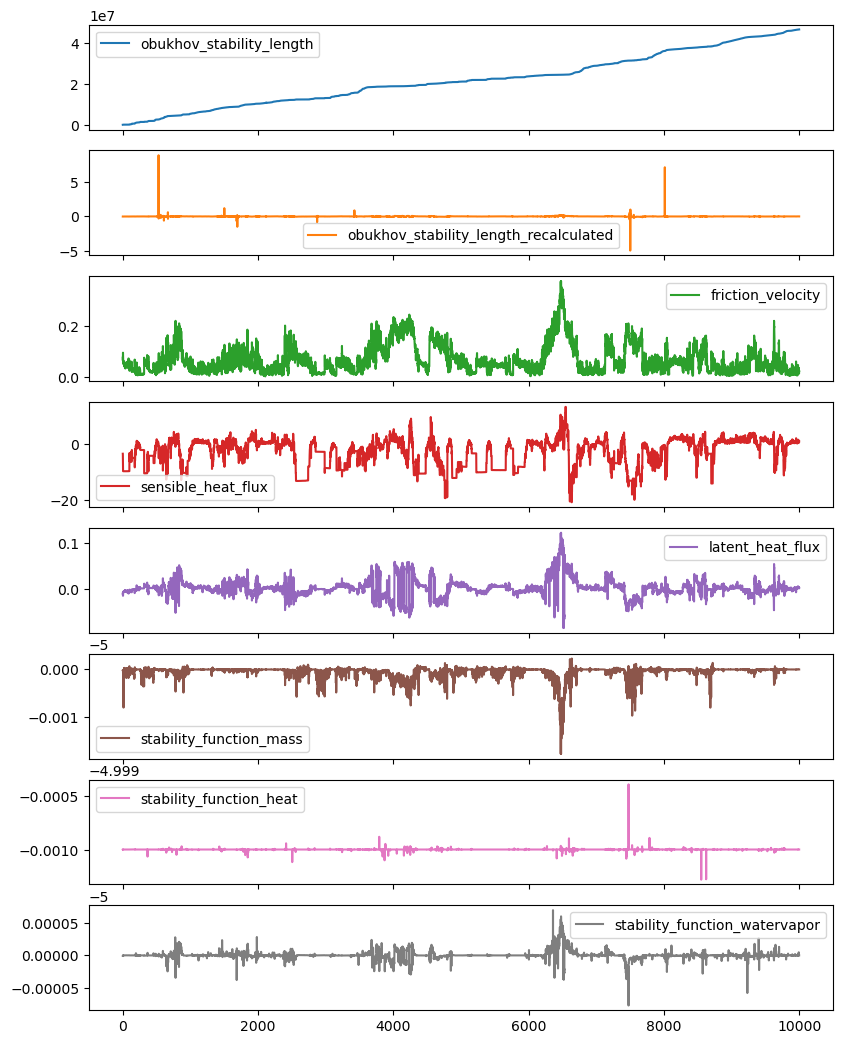

In [140]:
merged_df[[
    'obukhov_stability_length','obukhov_stability_length_recalculated','friction_velocity','sensible_heat_flux','latent_heat_flux',
    'stability_function_mass','stability_function_heat','stability_function_watervapor'
]].plot(subplots=True, figsize=(9.6, 12.8))

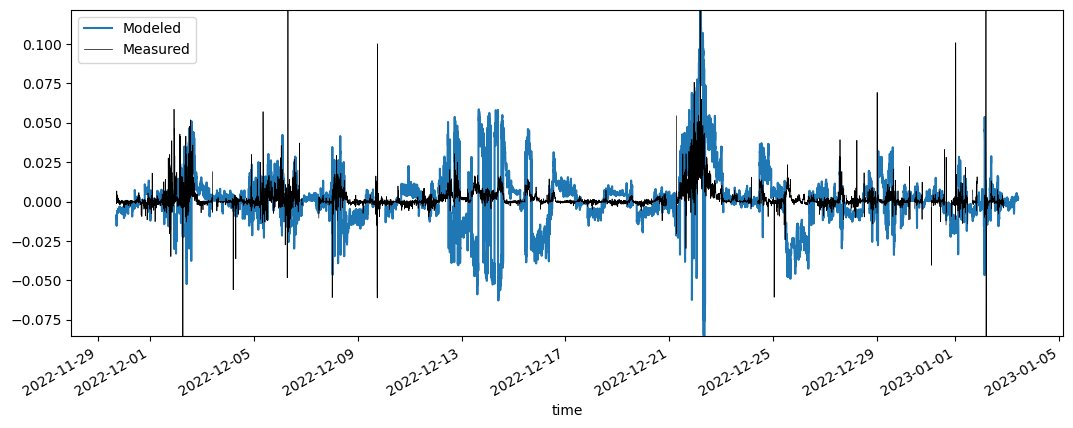

In [194]:
plt.figure(figsize=(12.8, 4.8))
merged_df.plot(x='time', y='latent_heat_flux', label='Modeled', ax = plt.gca())
merged_df.plot(x='time', y='w_h2o__3m_c', label='Measured', color='black', linewidth=0.5, ax = plt.gca())
plt.ylim(merged_df['latent_heat_flux'].min(), merged_df['latent_heat_flux'].max())
plt.legend()

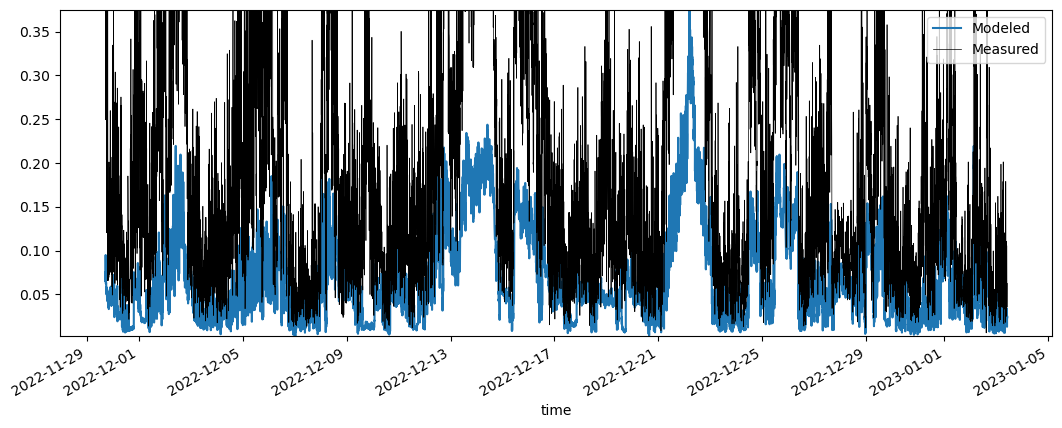

In [195]:
plt.figure(figsize=(12.8, 4.8))
merged_df.plot(x='time', y='friction_velocity', label='Modeled', ax = plt.gca())
merged_df.plot(x='time', y='u*_3m_c', label='Measured', color='black', linewidth=0.5, ax = plt.gca())
plt.ylim(merged_df['friction_velocity'].min(), merged_df['friction_velocity'].max())
plt.legend()

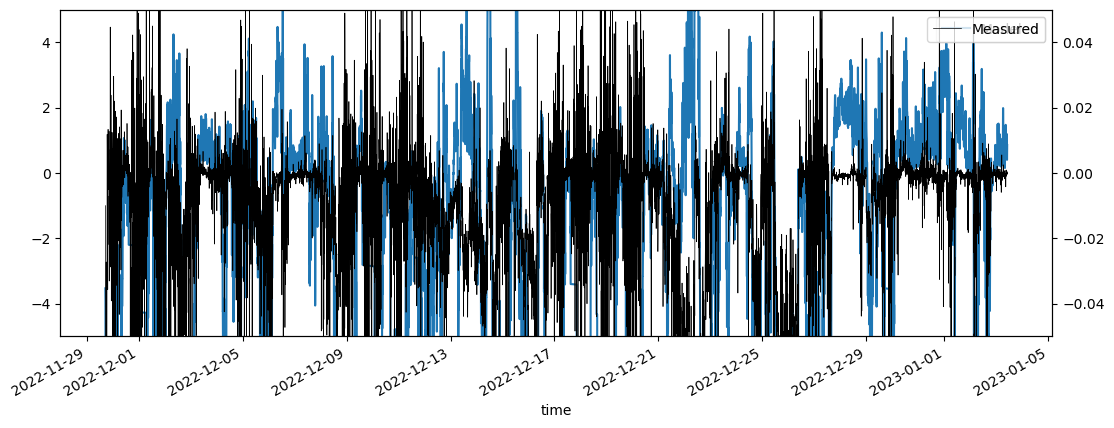

In [198]:
plt.figure(figsize=(12.8, 4.8))
merged_df.plot(x='time', y='sensible_heat_flux', label='Modeled', ax = plt.gca())
plt.gca().set_ylim(-5,5)
merged_df.plot(x='time', y='w_tc__3m_c', label='Measured', color='black', linewidth=0.5, ax = plt.twinx())
plt.gca().set_ylim(-0.05,0.05)

plt.legend()

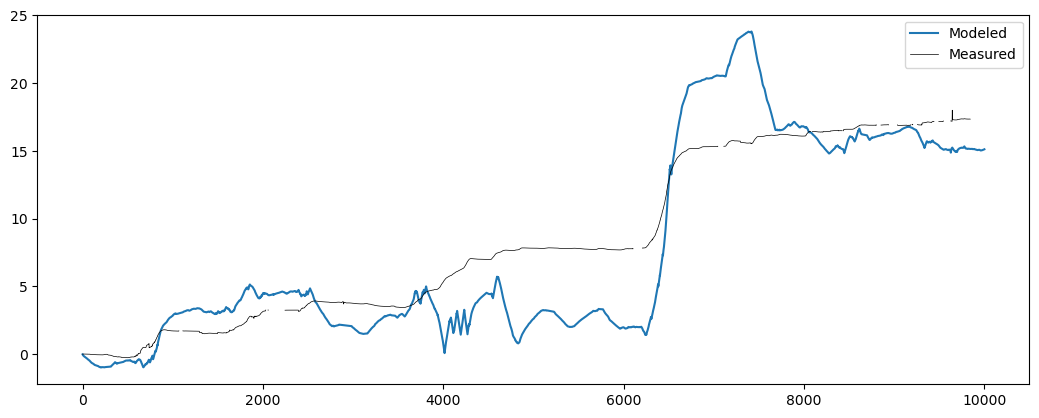

In [199]:
plt.figure(figsize=(12.8, 4.8))
merged_df['latent_heat_flux'].cumsum().plot(label='Modeled')
merged_df['w_h2o__3m_c'].cumsum().plot(label='Measured', color='black', linewidth=0.5)
plt.legend()

In [200]:
merged_df['Tpot_grad'] = (merged_df['Tpot_3m_c'] - merged_df['Tsurfpot_rad_c']) / 3
merged_df['mixingratio_grad'] = (merged_df['mixingratio_3m_c'] - merged_df['Tsurfmixingratio_rad_c']) / 3

Text(0.5, 0.98, 'All data')

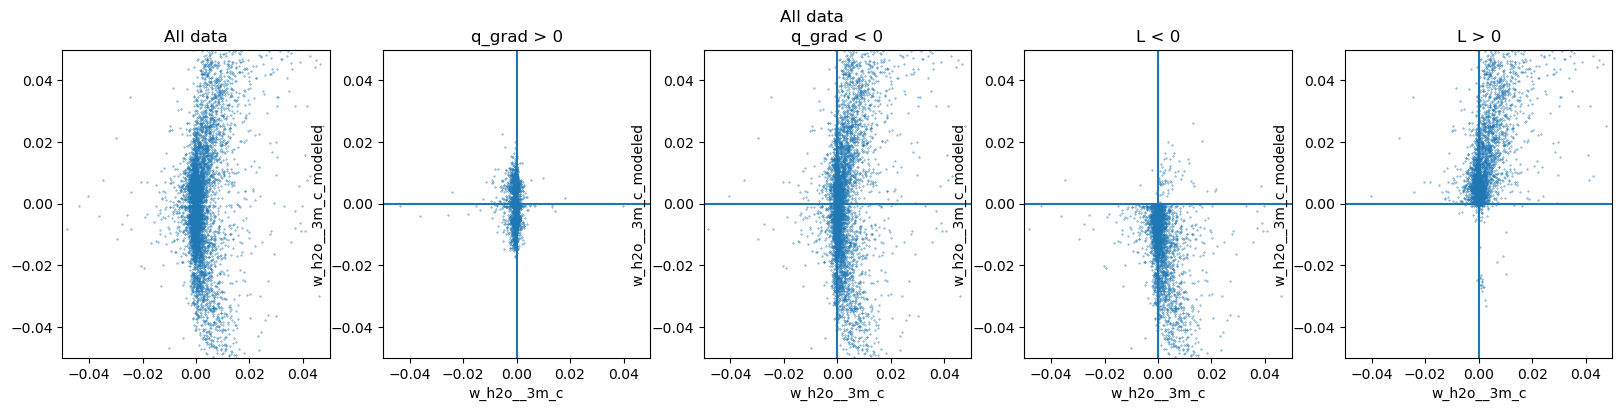

In [201]:
fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df['w_h2o__3m_c'],
model_src = merged_df['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].set_xlabel('w_h2o__3m_c')
axes[1].set_ylabel('w_h2o__3m_c_modeled')
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].set_xlabel('w_h2o__3m_c')
axes[2].set_ylabel('w_h2o__3m_c_modeled')
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].set_xlabel('w_h2o__3m_c')
axes[3].set_ylabel('w_h2o__3m_c_modeled')
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].set_xlabel('w_h2o__3m_c')
axes[4].set_ylabel('w_h2o__3m_c_modeled')
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)
plt.suptitle("All data")

Text(0.5, 0.98, 'No Blowing Snow')

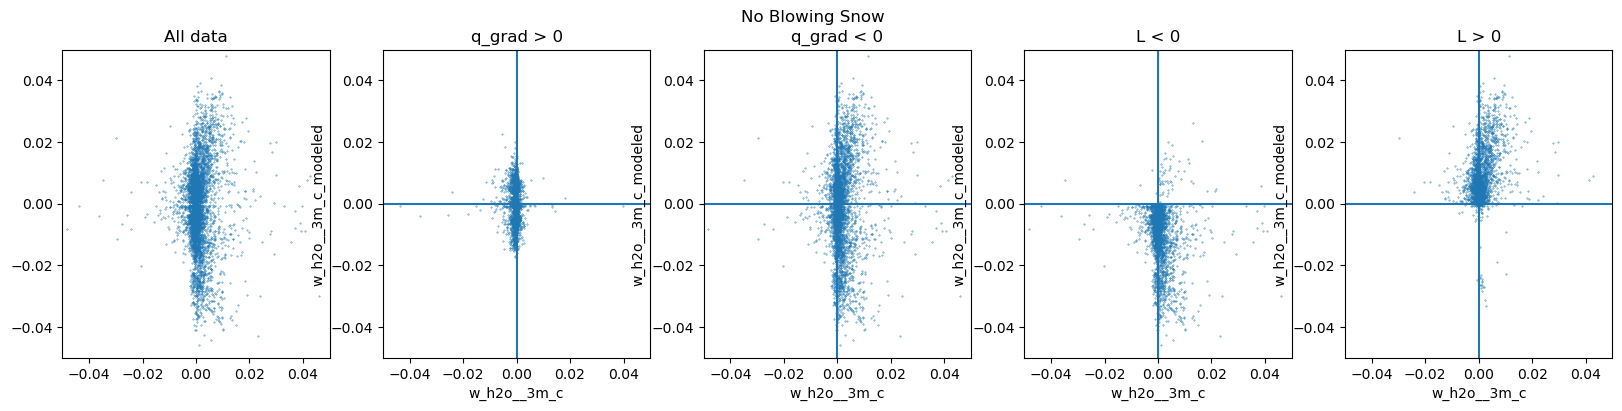

In [202]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

merged_df_src = merged_df[merged_df.time.isin(no_bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df_src['w_h2o__3m_c'],
model_src = merged_df_src['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].set_xlabel('w_h2o__3m_c')
axes[1].set_ylabel('w_h2o__3m_c_modeled')
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].set_xlabel('w_h2o__3m_c')
axes[2].set_ylabel('w_h2o__3m_c_modeled')
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].set_xlabel('w_h2o__3m_c')
axes[3].set_ylabel('w_h2o__3m_c_modeled')
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].set_xlabel('w_h2o__3m_c')
axes[4].set_ylabel('w_h2o__3m_c_modeled')
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)
plt.suptitle("No Blowing Snow")

Text(0.5, 0.98, 'Blowing Snow')

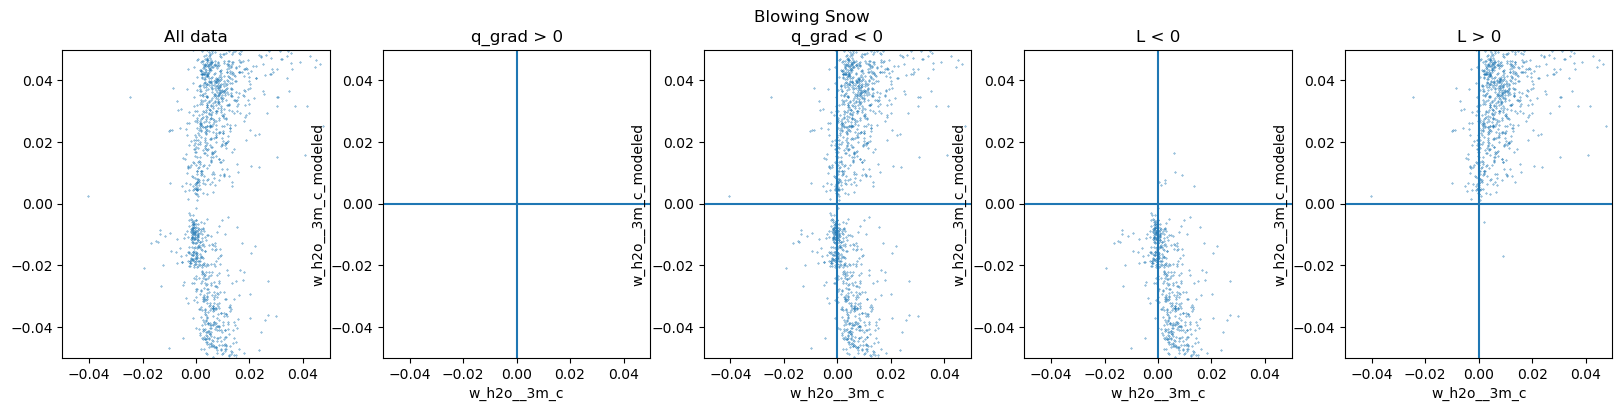

In [203]:
bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time

merged_df_src = merged_df[merged_df.time.isin(bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4))

# all data
axes[0].set_title("All data")
meas_src = merged_df_src['w_h2o__3m_c'],
model_src = merged_df_src['latent_heat_flux'],
axes[0].scatter(
    meas_src,
    model_src,
    s=0.1
)
axes[0].set_xlim(-0.05, 0.05)
axes[0].set_ylim(-0.05, 0.05)

# q gradient is positive (expected downward motion of water vapor)
axes[1].set_title("q_grad > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad > 0")
axes[1].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[1].set_xlabel('w_h2o__3m_c')
axes[1].set_ylabel('w_h2o__3m_c_modeled')
axes[1].axvline(0)
axes[1].axhline(0)
axes[1].set_xlim(-0.05, 0.05)
axes[1].set_ylim(-0.05, 0.05)

# q gradient is negative (expected upward motion of water vapor)
axes[2].set_title("q_grad < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("mixingratio_grad < 0")

axes[2].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[2].set_xlabel('w_h2o__3m_c')
axes[2].set_ylabel('w_h2o__3m_c_modeled')
axes[2].axvline(0)
axes[2].axhline(0)
axes[2].set_xlim(-0.05, 0.05)
axes[2].set_ylim(-0.05, 0.05)

# L < 0
axes[3].set_title("L < 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated < 0")

axes[3].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[3].set_xlabel('w_h2o__3m_c')
axes[3].set_ylabel('w_h2o__3m_c_modeled')
axes[3].axvline(0)
axes[3].axhline(0)
axes[3].set_xlim(-0.05, 0.05)
axes[3].set_ylim(-0.05, 0.05)

# L > 0
axes[4].set_title("L > 0")
src = merged_df_src.copy()
src['w_h2o__3m_c_modeled'] = src['latent_heat_flux']
src = src.query("obukhov_stability_length_recalculated > 0")

axes[4].scatter(
    src['w_h2o__3m_c'],
    src['w_h2o__3m_c_modeled'],
    s=0.1
)
axes[4].set_xlabel('w_h2o__3m_c')
axes[4].set_ylabel('w_h2o__3m_c_modeled')
axes[4].axvline(0)
axes[4].axhline(0)
axes[4].set_xlim(-0.05, 0.05)
axes[4].set_ylim(-0.05, 0.05)
plt.suptitle("Blowing Snow")